In [37]:
import math
from telnetlib import X3PAD
import numpy as np
import matplotlib.pyplot as plt

class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

        self._backward = lambda : None

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __repr__(self) -> str:
        return "Value(" + str(self.data) + ")"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            self._backward()
            other._backward()
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int or floats"
        n = self.data
        out = Value(n**other, (self, ), 'pow')

        def _backward():
            self.grad += other * n**(other - 1.0) * out.grad
        out._backward = _backward
        return out

# 2**3 = 2*2*2 = 8

# dérivée de x² =   2x
# dérivée de x 3 =  3x2

# dérivée de x-1 = 1 / (x2)

# dérivée de x ^ y = (y-1)  x ^ (y-1) * 

    def exp(self):
        n = self.data
        m = math.e ** n
        out = Value(m, (self, ), 'exp')
        def _backward():
            self.grad += m * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        m = (math.exp(2*n) - 1.0 ) / (math.exp(2*n) + 1.0)
        out = Value(m, (self, ), 'tanh')
        def _backward():
            self.grad += (1.0 - m**2.0) * out.grad
            pass
        out._backward = _backward
        return out
    
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value( 10.0, label="c")
e = a*b
e.label = 'e'
d = e + c
d.label='d'

f = Value(-2.0, label="f")
L = d*f
L.label = 'L'
L.grad = 1.0

In [38]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


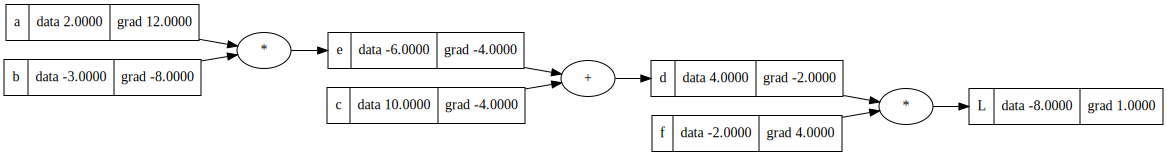

In [39]:
L.backward()
draw_dot(L)


In [40]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def parameters(self):
        return self.w + [self.b]

    def __call__(self, x):
        act = sum( (wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(0.9807631518692654)

In [41]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [ Neuron(nin) for _ in range(nout)]

    def __call__(self, x) :
        out = [neuron(x) for neuron in self.neurons]
        return out if len(out) != 1 else out[0]
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters() ]

x = [2.0, 3.0]
n = Layer(2, 3)
n(x)
n.parameters()

[Value(-0.02554228166781236),
 Value(-0.5116103283231261),
 Value(0.6292712452538913),
 Value(-0.04635693697514642),
 Value(-0.8445792558289826),
 Value(-0.5920635616740018),
 Value(0.8806526454443471),
 Value(-0.2392454239600832),
 Value(-0.3095745246379451)]

In [49]:
class MLP:
    def __init__(self, nin, nouts) -> None:
        sizes = [nin] + nouts

        self.layers = [ Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]

mlp = MLP(3, [4,4,1])
mlp(x)

len(mlp.parameters())

41

In [53]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# ypreds = [mlp(x) for x in xs]

# loss = sum([ ((ypred - y)**2.0) for (y, ypred) in zip(ys, ypreds) ])
# print(loss)
# loss.grad = 1.0
# loss.backward()
# mlp.layers[0].neurons[0].w[0].grad

for step in range(500):

  ypreds = [mlp(x) for x in xs] 
  loss = sum([ ((ypred - y)**2.0) for (y, ypred) in zip(ys, ypreds) ])

  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()

  for p in mlp.parameters():
    p.data -= 0.05 * p.grad
  
print(step, loss.data)
ypreds

499 0.00024485787135437983


[Value(0.9933311123186056),
 Value(-0.9881169402792896),
 Value(-0.9966948227913572),
 Value(0.9930535977844048)]

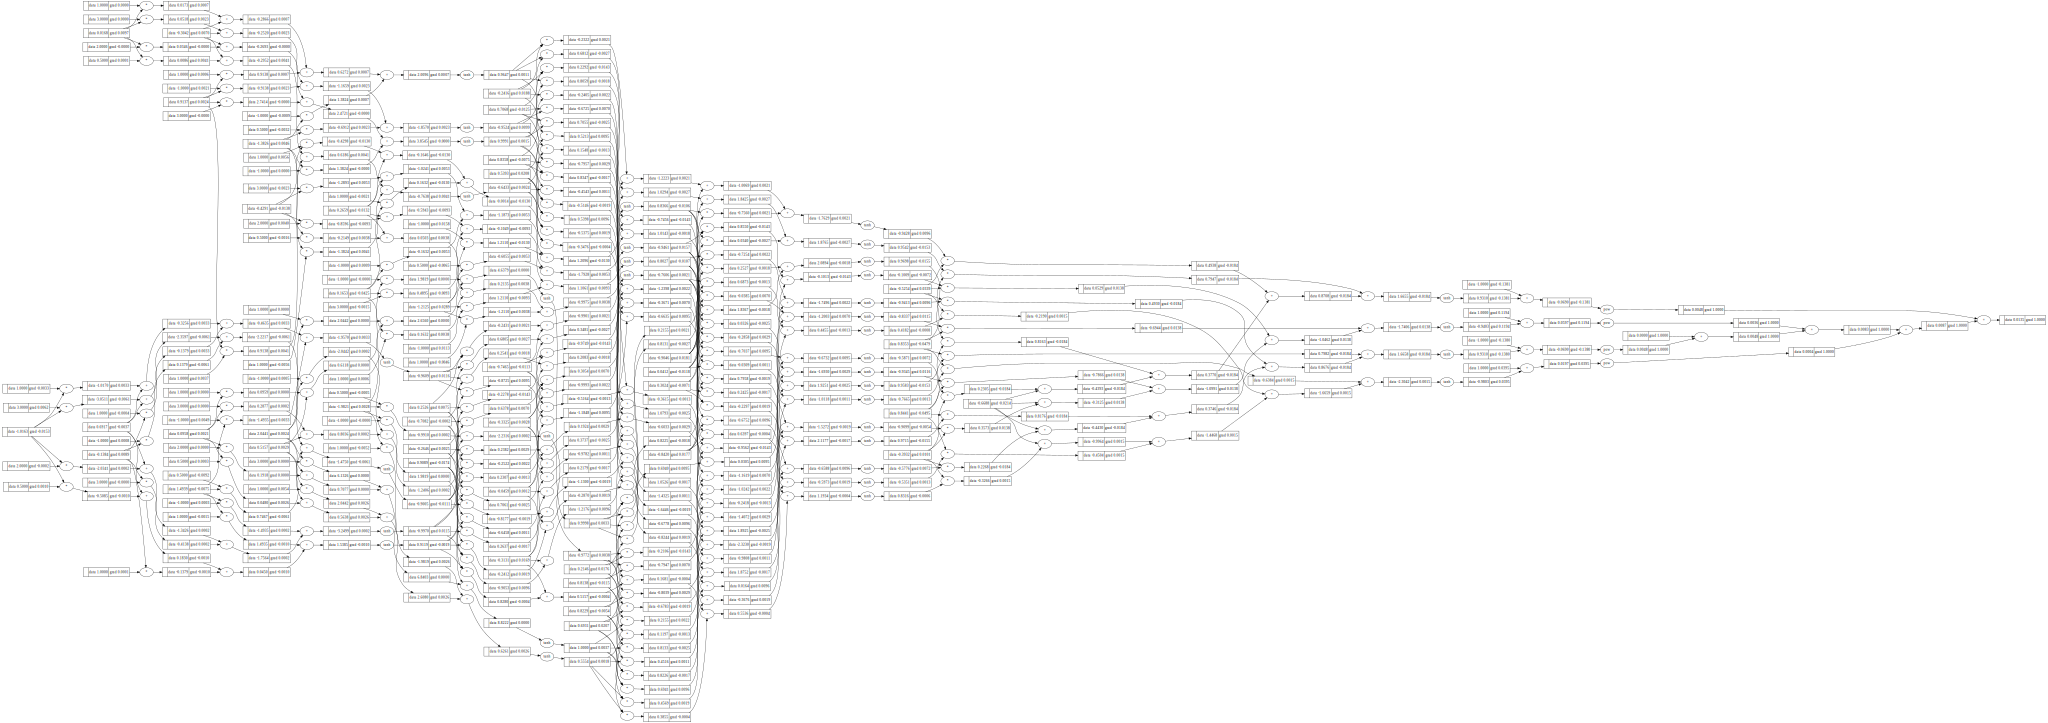

In [44]:
draw_dot(loss)